## Import Libraries

In [ ]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.simplefilter('ignore')

In [ ]:
def predict_proba(model, data):
    """
    Menggunakan model yang telah di-train untuk melakukan prediksi probabilitas kelas.

    Parameters:
    model (objek model sklearn): Model yang telah di-train.
    data (numpy array atau pandas DataFrame): Data yang akan dijadikan sebagai input untuk prediksi.

    Returns:
    probabilitas (numpy array): Probabilitas prediksi kelas (array 2D).
    """
    probabilitas = model.predict_proba(data)
    print("Probabilitas prediksi kelas:")
    for row in probabilitas:
        print(f"Class 0: {row[0]:.3f}, Class 1: {row[1]:.3f}")
    return probabilitas

In [ ]:
def modelPredictionResult(classifier, input_data, output_data):
    """
    Menggunakan model klasifikasi untuk melakukan prediksi pada data input, menghitung confusion matrix,
    dan menghasilkan classification report.

    Parameters:
        classifier (objek model): Model klasifikasi yang akan digunakan untuk prediksi.
        input_data (DataFrame): Data input yang akan digunakan untuk prediksi.
        output_data (Series): Data output yang berisi label sebenarnya.

    Returns:
        predicted_classes (array): Array berisi hasil prediksi model.
        report (str): Laporan klasifikasi yang berisi informasi seperti precision, recall, dan F1-score.
    """
    # Prediksi menggunakan model classifier dan menghitung confusion matrix
    predicted_classes = classifier.predict(input_data)
    confusion = confusion_matrix(output_data, predicted_classes)
    TN, FN, FP, TP = confusion.ravel()

    # Print Confusion Matrix
    print("Confusion Matrix:")
    print(f"[True Negative: {TN}\tFalse Negative: {FN}]")
    print(f"[False Positive: {FP}\tTrue Positive: {TP}]")

    # Menghasilkan classification report
    report = classification_report(output_data, predicted_classes)
    print("Classification Report:")
    print(report)

    return predicted_classes, report

In [ ]:
def classScore(model_prediction, output_data):
    """
    Menghitung metrik klasifikasi seperti akurasi, recall, F1-score, dan presisi dari hasil prediksi model.

    Parameters:
        model_prediction (array-like): Hasil prediksi model.
        output_data (array-like): Data keluaran yang sebenarnya.

    Returns:
        score_summary (str): Ringkasan skor klasifikasi dalam format teks.
    """

    # Menghitung akurasi model
    accuracy = accuracy_score(output_data, model_prediction)

    # Menghitung recall model
    recall = recall_score(output_data, model_prediction)

    # Menghitung F1-score model
    f1_score_value = f1_score(output_data, model_prediction)

    # Menghitung presisi model
    precision = precision_score(output_data, model_prediction)

    # Membuat ringkasan skor dalam format yang sesuai
    score_summary = f"Classification Score Summary\nClassifier Accuracy score: {accuracy:.2f}\nClassifier Recall score: {recall:.2f}\nClassifier f1-score: {f1_score_value:.2f}\nClassifier precision: {precision:.2f}"

    # Mencetak ringkasan skor
    print(score_summary)

    return score_summary

In [ ]:
def rocAucResult(model_prediction, output_data, model_name):
    """
    Menghitung dan menampilkan Area Under the Receiver Operating Characteristic (AUC-ROC) score
    serta menggambar kurva Receiver Operating Characteristic (ROC) dari hasil prediksi model.

    Parameters:
        model_prediction (array-like): Hasil prediksi model.
        output_data (array-like): Data keluaran yang sebenarnya.
        model_name (str): Nama model untuk digunakan dalam judul grafik.

    Returns:
        None: Fungsi ini digunakan untuk menampilkan grafik ROC dan nilai AUC-ROC, bukan mengembalikan nilai.
    """

    # Menghitung AUC-ROC score
    auc_roc = roc_auc_score(output_data, model_prediction)

    # Menghitung kurva ROC
    fpr, tpr, thresholds = roc_curve(output_data, model_prediction)

    # Menggambar kurva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({model_name})')
    plt.legend(loc='lower right')

    # Menambahkan nilai AUC sebagai teks di grafik
    plt.text(0.6, 0.2, 'AUC = %0.2f' % auc_roc, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

## Load Dataset

In [ ]:
# Load Data
df = pd.read_csv('/content/telco_customer_churn.csv')
df

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [ ]:
# drop kolom kategorik yang tidak dibutuhkan
df.drop(columns=['state', 'area_code'], inplace=True)
df.head(2)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no


In [ ]:
df.shape

(4250, 18)

## Data Cleansing & Preprocessing

In [ ]:
# cek data duplicate
df.duplicated().sum()

0

In [ ]:
# cek data missing
df.isnull().sum()

account_length                   0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

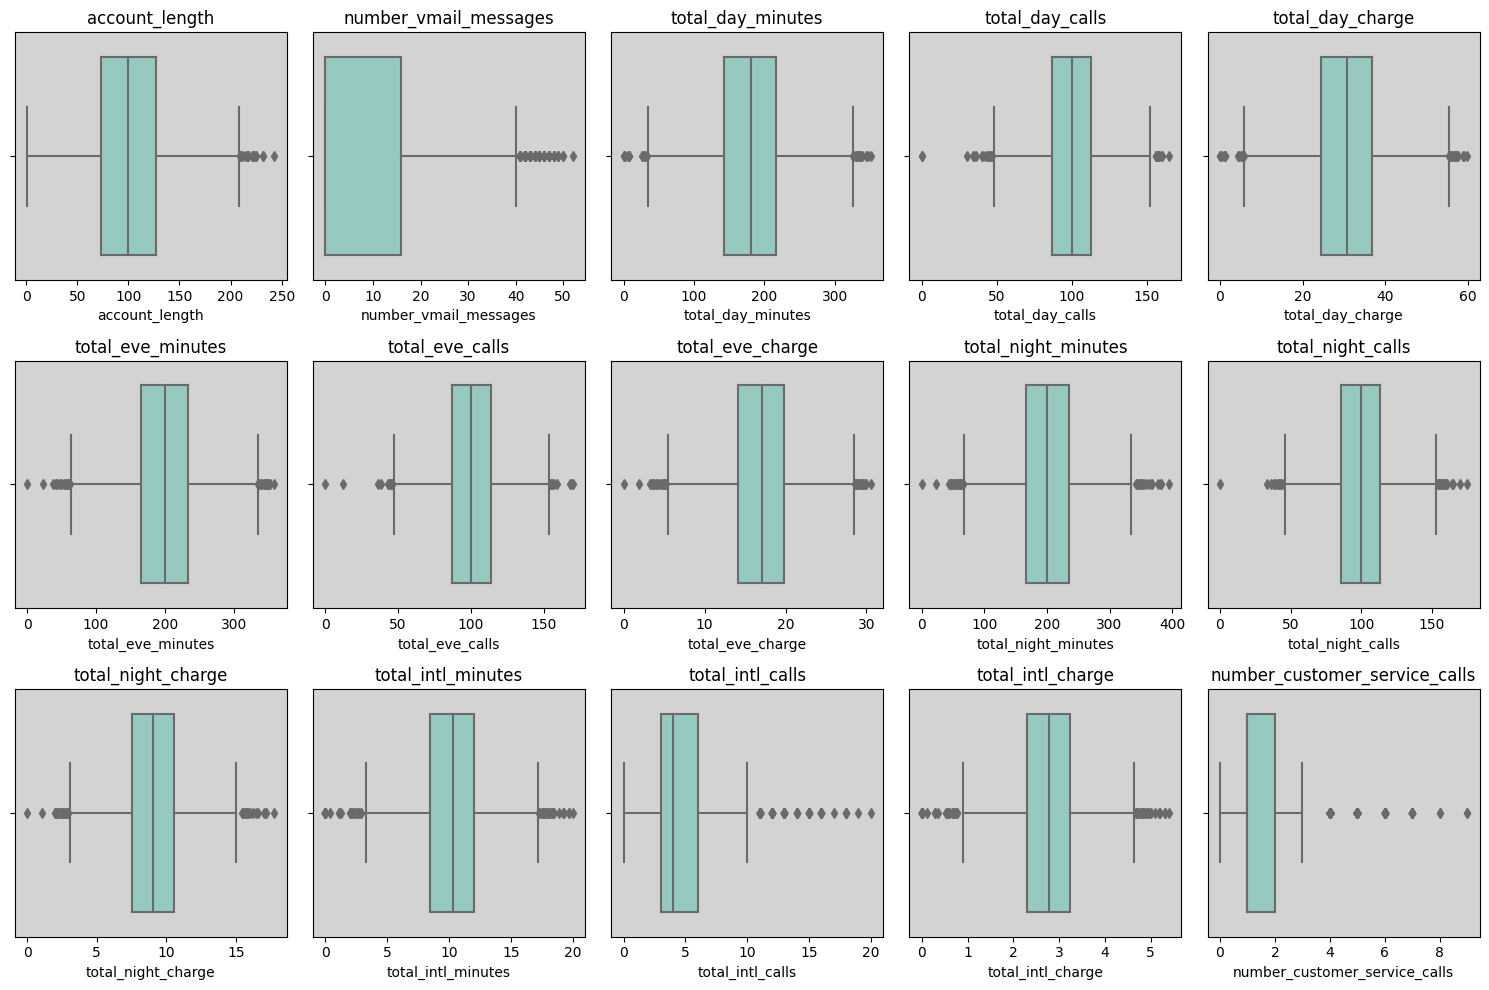

In [ ]:
#cek outlier

# Daftar kolom numerik yang ingin Anda buat boxplot-nya
num_col = ['account_length', 'number_vmail_messages', 'total_day_minutes',
           'total_day_calls', 'total_day_charge', 'total_eve_minutes',
           'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
           'total_night_calls', 'total_night_charge', 'total_intl_minutes',
           'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']

# Membuat tata letak boxplot
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

# Mengatur warna latar belakang
fig.patch.set_facecolor('white')

# Mengatur warna bar boxplot
sns.set_palette('Set3')

# Iterasi untuk membuat setiap boxplot
for i, col in enumerate(num_col):
    row = i // 5
    col = i % 5
    sns.boxplot(x=df[num_col[i]], ax=axes[row][col])
    axes[row][col].set_title(num_col[i])
    axes[row][col].set_facecolor('lightgray')  # Mengatur warna latar belakang subplot

# Menampilkan boxplot
plt.tight_layout()
plt.show()

In [ ]:
# Handling Outlier

num_col = ['account_length', 'number_vmail_messages', 'total_day_minutes',
           'total_day_calls', 'total_day_charge', 'total_eve_minutes',
           'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
           'total_night_calls', 'total_night_charge', 'total_intl_minutes',
           'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']

# Buat salinan DataFrame
df_cleaned = df.copy()

# Cek dan hapus outlier pada setiap kolom
for col_name in num_col:
    # Quartile 1
    val_Q1 = np.percentile(df_cleaned[col_name], 25, interpolation='midpoint')

    # Quartile 3
    val_Q3 = np.percentile(df_cleaned[col_name], 75, interpolation='midpoint')

    # IQR
    val_IQR = val_Q3 - val_Q1
    print("Removing outliers from", col_name)
    print("Old Data Shape:", df_cleaned.shape)

    # Upper bound
    upper = df_cleaned[df_cleaned[col_name] >= (val_Q3 + 1.5 * val_IQR)]
    # Lower bound
    lower = df_cleaned[df_cleaned[col_name] <= (val_Q1 - 1.5 * val_IQR)]

    # Hapus outlier berdasarkan indeks yang ada
    df_cleaned = df_cleaned.drop(upper.index)
    df_cleaned = df_cleaned.drop(lower.index)

    print("New Data Shape:", df_cleaned.shape)

# Mengatur ulang indeks DataFrame
df_cleaned.reset_index(inplace=True, drop=True)

Removing outliers from account_length
Old Data Shape: (4250, 18)
New Data Shape: (4229, 18)
Removing outliers from number_vmail_messages
Old Data Shape: (4229, 18)
New Data Shape: (4121, 18)
Removing outliers from total_day_minutes
Old Data Shape: (4121, 18)
New Data Shape: (4095, 18)
Removing outliers from total_day_calls
Old Data Shape: (4095, 18)
New Data Shape: (4063, 18)
Removing outliers from total_day_charge
Old Data Shape: (4063, 18)
New Data Shape: (4061, 18)
Removing outliers from total_eve_minutes
Old Data Shape: (4061, 18)
New Data Shape: (4025, 18)
Removing outliers from total_eve_calls
Old Data Shape: (4025, 18)
New Data Shape: (4002, 18)
Removing outliers from total_eve_charge
Old Data Shape: (4002, 18)
New Data Shape: (4000, 18)
Removing outliers from total_night_minutes
Old Data Shape: (4000, 18)
New Data Shape: (3965, 18)
Removing outliers from total_night_calls
Old Data Shape: (3965, 18)
New Data Shape: (3935, 18)
Removing outliers from total_night_charge
Old Data Sh

In [ ]:
df.shape, df_cleaned.shape

((4250, 18), (3476, 18))

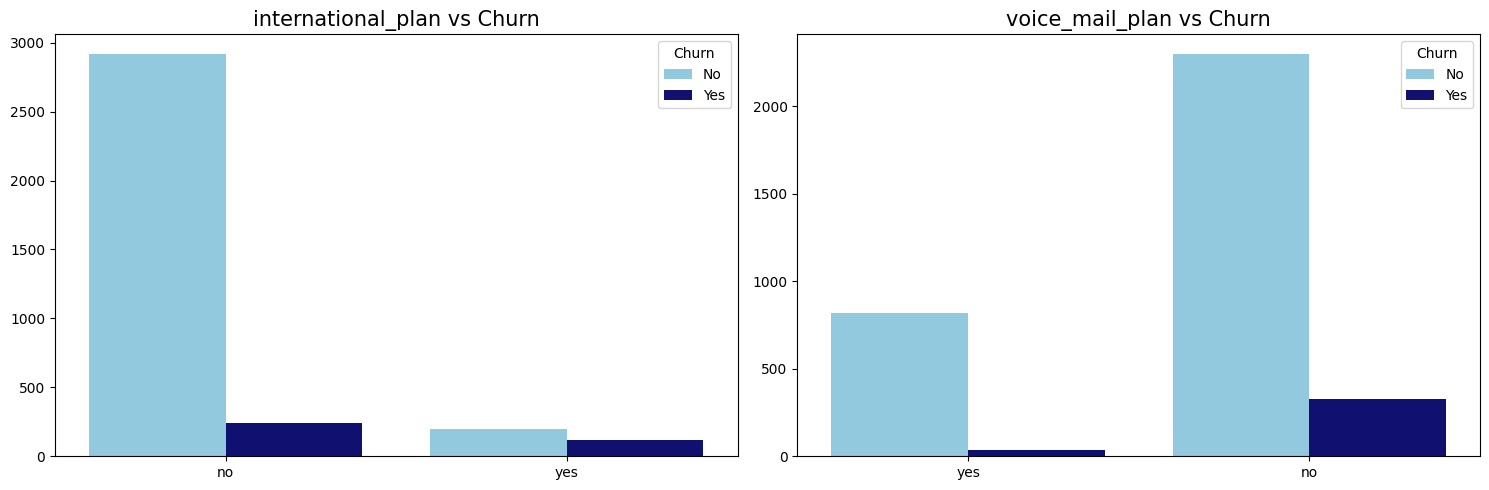

In [ ]:
obj = ['international_plan', 'voice_mail_plan']

color_palette = {"no": "skyblue", "yes": "navy"}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, column in enumerate(obj):
    sns.countplot(data=df_cleaned, x=column, hue='churn', ax=axs[i], palette=color_palette)
    axs[i].set_title(f'{column} vs Churn', fontsize=15)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].legend(title='Churn', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

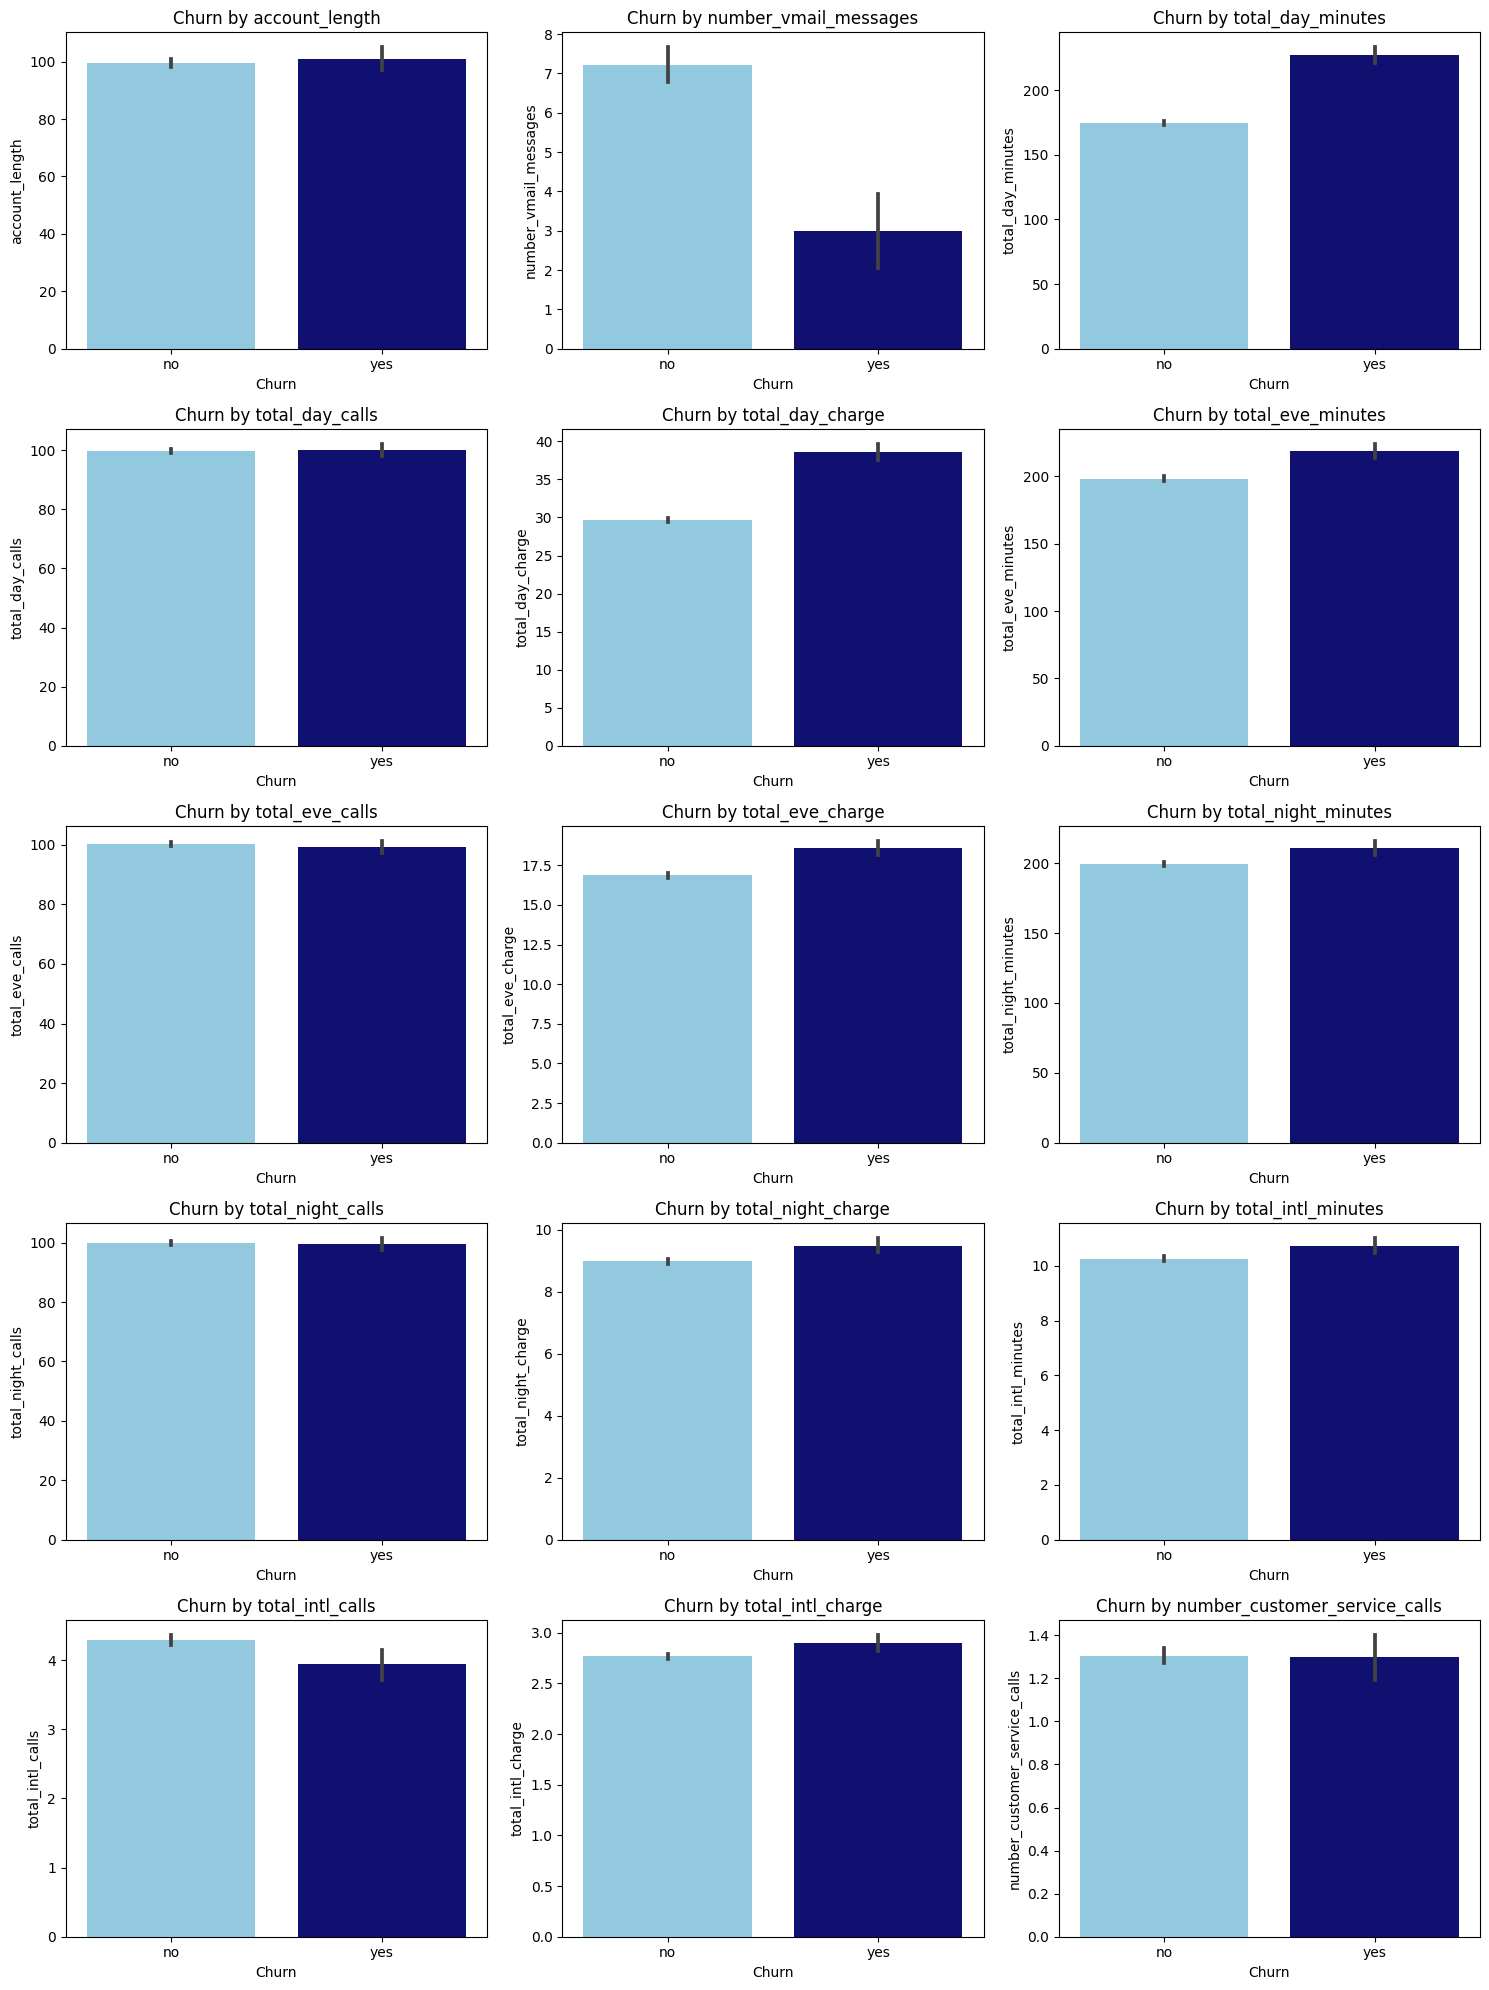

In [ ]:
# Daftar kolom numerik yang akan dianalisis
numeric_columns = ['account_length', 'number_vmail_messages', 'total_day_minutes',
                   'total_day_calls', 'total_day_charge', 'total_eve_minutes',
                   'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
                   'total_night_calls', 'total_night_charge', 'total_intl_minutes',
                   'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']

# Buat subplot sejumlah kolom numerik dalam grid 5x3
fig, axs = plt.subplots(5, 3, figsize=(15, 20))

# Iterasi melalui setiap kolom numerik dan membuat grafik barplot
for i, column in enumerate(numeric_columns):
    row = i // 3  # Hitung baris
    col = i % 3   # Hitung kolom
    sns.barplot(data=df_cleaned, x='churn', y=column, ax=axs[row, col], palette={"no": "skyblue", "yes": "navy"})
    axs[row, col].set_title(f'Churn by {column}', fontsize=12)
    axs[row, col].set_xlabel('Churn', fontsize=10)
    axs[row, col].set_ylabel(column, fontsize=10)

# Menghapus subplot yang tidak digunakan
for i in range(len(numeric_columns), 15):
    fig.delaxes(axs[i // 3, i % 3])

plt.tight_layout()
plt.show()

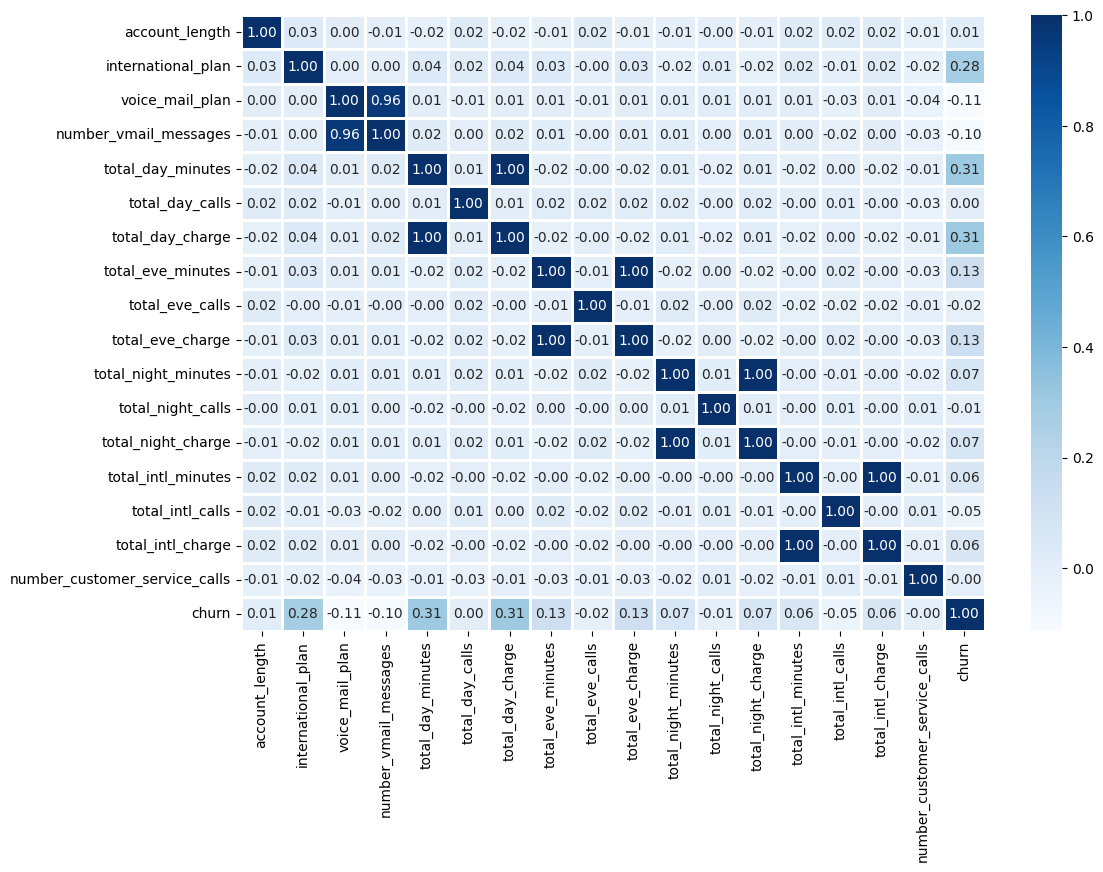

In [ ]:
# Hitung matriks korelasi
data = df_cleaned.copy()
label_encoder = preprocessing.LabelEncoder()

for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])

corr_matrix = data.corr()

# Buat heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=2)
plt.show()

Variabel total_day_minutes dan total_day_charge memiliki korelasi tertinggi terhadap Churn

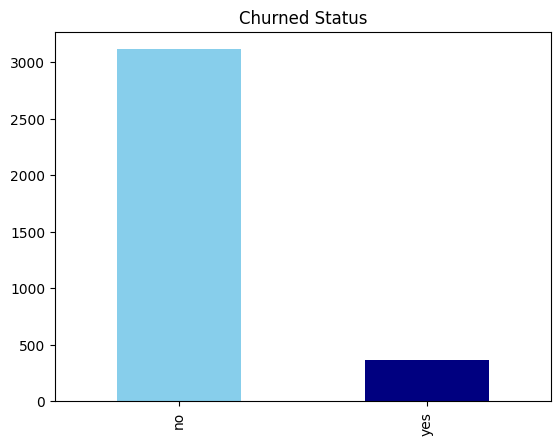

In [ ]:
# cek distribusi variable output
churn_counts = df_cleaned['churn'].value_counts()
ax = churn_counts.plot(kind='bar', color=['skyblue', 'navy'])

plt.title('Churned Status')
plt.show()

In [ ]:
# mengubah variable output menjadi numeric
df_cleaned['churn'] = df_cleaned['churn'].replace({'yes': 1, 'no': 0})
df_cleaned['churn'] = df_cleaned['churn'].astype('int')
df_cleaned.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
3,147,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0
4,141,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0


### Input-Output Split

In [ ]:
X = df_cleaned.drop(['churn'], axis = 1)
y = df_cleaned['churn']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 3476 non-null   int64  
 1   international_plan             3476 non-null   object 
 2   voice_mail_plan                3476 non-null   object 
 3   number_vmail_messages          3476 non-null   int64  
 4   total_day_minutes              3476 non-null   float64
 5   total_day_calls                3476 non-null   int64  
 6   total_day_charge               3476 non-null   float64
 7   total_eve_minutes              3476 non-null   float64
 8   total_eve_calls                3476 non-null   int64  
 9   total_eve_charge               3476 non-null   float64
 10  total_night_minutes            3476 non-null   float64
 11  total_night_calls              3476 non-null   int64  
 12  total_night_charge             3476 non-null   f

In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

In [ ]:
# Sanity check hasil splitting
df_cleaned.shape, X.shape, y.shape

((3476, 18), (3476, 17), (3476,))

### Train-Test Split

In [ ]:
 # Train test split
 X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size=0.2, random_state=123)

In [ ]:
# Sanity check hasil splitting
print(X_train.shape)
print(X_test.shape)

(2780, 17)
(696, 17)


In [ ]:
# Ratio
X_test.shape[0] / X.shape[0]

0.2002301495972382

In [ ]:
X_train.isnull().sum()

account_length                   0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
dtype: int64

### Feature Encoding

In [ ]:
X_train_categorical = X_train[['international_plan', 'voice_mail_plan']]
categorical_ohe = pd.get_dummies(X_train_categorical)

In [ ]:
categorical_ohe.head(3)

,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
141,1,0,1,0
2295,1,0,1,0
2256,1,0,0,1


In [ ]:
ohe_columns = categorical_ohe.columns
ohe_columns

Index(['international_plan_no', 'international_plan_yes', 'voice_mail_plan_no',
       'voice_mail_plan_yes'],
      dtype='object')

In [ ]:
X_train_numeric = X_train[['account_length', 'number_vmail_messages', 'total_day_minutes',
           'total_day_calls', 'total_day_charge', 'total_eve_minutes',
           'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
           'total_night_calls', 'total_night_charge', 'total_intl_minutes',
           'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']]

# Menggabungkan X_train_numeric dan categorical_ohe
X_train_concat = pd.concat([X_train_numeric, categorical_ohe], axis=1)

In [ ]:
X_train_concat.isnull().any()

account_length                   False
number_vmail_messages            False
total_day_minutes                False
total_day_calls                  False
total_day_charge                 False
total_eve_minutes                False
total_eve_calls                  False
total_eve_charge                 False
total_night_minutes              False
total_night_calls                False
total_night_charge               False
total_intl_minutes               False
total_intl_calls                 False
total_intl_charge                False
number_customer_service_calls    False
international_plan_no            False
international_plan_yes           False
voice_mail_plan_no               False
voice_mail_plan_yes              False
dtype: bool

In [ ]:
X_train.shape , X_train_concat.shape

((2780, 17), (2780, 19))

### Standardizing Variables

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_concat)

def scaler_transform(data, scaler):
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data_scaled)
    data_scaled.columns = data.columns
    data_scaled.index = data.index
    return data_scaled

X_train_scaled = scaler_transform(data=X_train_concat, scaler=scaler)
X_train_scaled.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
141,-0.157359,-0.553537,-0.020958,-0.345217,-0.021132,-0.451606,-0.101131,-0.451904,0.506712,1.605110,0.504811,0.462405,0.855454,0.468952,1.726563,0.322569,-0.322569,0.575135,-0.575135
2295,1.519986,-0.553537,-0.202117,0.750156,-0.201730,-0.054970,0.254877,-0.056130,-0.139062,-0.913732,-0.137537,0.501661,-0.115026,0.498033,-0.326847,0.322569,-0.322569,0.575135,-0.575135
2256,-0.259016,1.381189,-1.575109,-0.084414,-1.574726,0.142311,-1.677740,0.141758,0.287354,1.348086,0.286140,-1.735946,-1.085506,-1.741156,-1.353551,0.322569,-0.322569,-1.738722,1.738722
2390,-0.513159,-0.553537,-2.168166,1.271762,-2.168120,0.075858,-0.457140,0.075795,1.111484,0.525606,1.110714,1.875630,-1.085506,1.879350,-0.326847,0.322569,-0.322569,0.575135,-0.575135
2491,-0.538573,1.542417,0.164015,-0.084414,0.163954,-0.179568,-1.677740,-0.180725,0.338605,-1.633402,0.336252,0.383892,-0.600266,0.381711,-1.353551,0.322569,-0.322569,-1.738722,1.738722


In [ ]:
X_train_scaled.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
count,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03,2.780000e+03
mean,6.645364e-17,6.389773e-18,1.047923e-16,-1.789136e-16,-6.709261e-16,6.492009e-16,-2.223641e-16,1.124600e-16,-1.405750e-17,3.092650e-16,-2.415334e-16,-5.047921e-16,-2.044727e-16,-4.217250e-17,-4.025557e-17,1.354632e-16,5.367409e-17,-1.916932e-17,1.916932e-17
std,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00
min,-2.495476e+00,-5.535371e-01,-2.721177e+00,-2.640285e+00,-2.721132e+00,-2.723443e+00,-2.694907e+00,-2.723942e+00,-2.722158e+00,-2.764310e+00,-2.720595e+00,-2.678096e+00,-1.570746e+00,-2.671728e+00,-1.353551e+00,-3.100111e+00,-3.225691e-01,-1.738722e+00,-5.751350e-01
25%,-6.656449e-01,-5.535371e-01,-6.983963e-01,-6.581809e-01,-6.980948e-01,-6.945725e-01,-6.605732e-01,-6.937660e-01,-6.925828e-01,-6.567075e-01,-6.933270e-01,-6.760267e-01,-6.002663e-01,-6.797223e-01,-3.268466e-01,3.225691e-01,-3.225691e-01,5.751350e-01,-5.751350e-01
50%,-4.872601e-03,-5.535371e-01,9.719879e-04,1.990735e-02,1.302900e-03,7.329469e-03,5.854199e-04,7.389792e-03,6.493136e-03,1.155687e-02,8.244431e-03,3.058599e-02,-1.150263e-01,3.274680e-02,-3.268466e-01,3.225691e-01,-3.225691e-01,5.751350e-01,-5.751350e-01
75%,6.813140e-01,-5.535371e-01,6.827011e-01,6.458349e-01,6.821921e-01,6.791203e-01,6.617440e-01,6.798398e-01,7.014689e-01,6.798212e-01,7.007046e-01,6.586861e-01,3.702137e-01,6.579748e-01,6.998581e-01,3.225691e-01,-3.225691e-01,5.751350e-01,-5.751350e-01
max,2.663631e+00,2.590394e+00,2.709773e+00,2.680100e+00,2.710277e+00,2.740179e+00,2.746936e+00,2.741165e+00,2.726944e+00,2.736019e+00,2.727973e+00,2.582243e+00,2.796414e+00,2.577279e+00,1.726563e+00,3.225691e-01,3.100111e+00,5.751350e-01,1.738722e+00


**Hasil Standarisasi:**
Mean = 0
Standar Deviasi/Variance = 1

In [ ]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2780 entries, 141 to 3437
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 2780 non-null   float64
 1   number_vmail_messages          2780 non-null   float64
 2   total_day_minutes              2780 non-null   float64
 3   total_day_calls                2780 non-null   float64
 4   total_day_charge               2780 non-null   float64
 5   total_eve_minutes              2780 non-null   float64
 6   total_eve_calls                2780 non-null   float64
 7   total_eve_charge               2780 non-null   float64
 8   total_night_minutes            2780 non-null   float64
 9   total_night_calls              2780 non-null   float64
 10  total_night_charge             2780 non-null   float64
 11  total_intl_minutes             2780 non-null   float64
 12  total_intl_calls               2780 non-null  

**Balancing Data**

In [ ]:
# menggunakan teknik SMOTE
from imblearn.over_sampling import SMOTE

# Buat objek SMOTE
smt = SMOTE(sampling_strategy="minority", random_state=123)

# Fit objek SMOTE
X_train_smote, y_train_smote = smt.fit_resample(X_train_scaled, y_train)

In [ ]:
X_train_smote.shape

(4976, 19)

In [ ]:
# Menampilkan kolom-kolom
print(X_train_smote.columns)

print(y_train_smote.name)

Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'international_plan_no',
       'international_plan_yes', 'voice_mail_plan_no', 'voice_mail_plan_yes'],
      dtype='object')
churn


## Modelling

### Cross Validation

In [ ]:
# buat variabel untuk menyimpan best parameter di setiap model
cv_best_params = {}

**Logistic Regression**

In [ ]:
# Inisialisasi model Regresi Logistik
log_reg = LogisticRegression(solver="liblinear", random_state=123)

# parameter yang dicari
logreg_search_params = {
    "penalty": ["l1","l2"],
    "C": np.logspace(-5, 5, 20)
}

# Inisialisasi GridSearchCV dengan 10-fold CV
logreg_cv = GridSearchCV(estimator=log_reg, param_grid=logreg_search_params, cv=10)

In [ ]:
# Fitting Data
logreg_cv.fit(X = X_train_smote,
              y = y_train_smote)

GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=123, solver='liblinear'),
             param_grid={'C': array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05]),
                         'penalty': ['l1', 'l2']})

In [ ]:
logreg_cv.best_params_

{'C': 0.1623776739188721, 'penalty': 'l1'}

In [ ]:
cv_best_params["logistic reg"] = logreg_cv.best_params_

**Random Forest**

In [ ]:
# Inisialisasi model Random Forest
random_forest = RandomForestClassifier(criterion="gini",
                                       max_features="sqrt",
                                       random_state=123)
# Hyperparameter yang diuji
random_forest_hyparams = {
    "n_estimators": [200, 300, 400, 500, 600, 700]
}

# Inisialisasi GridSearchCV dengan 10-fold CV
random_forest_cv = GridSearchCV(estimator = random_forest,
                         param_grid = random_forest_hyparams,
                         cv = 10)

In [ ]:
# Fitting Data
random_forest_cv.fit(X = X_train_smote,
              y = y_train_smote)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=123),
             param_grid={'n_estimators': [200, 300, 400, 500, 600, 700]})

In [ ]:
random_forest_cv.best_params_

{'n_estimators': 200}

In [ ]:
cv_best_params["random forest"] = random_forest_cv.best_params_

**AdaBoost Classifier**

In [ ]:
# Inisialisasi model Adaboost
adaboost = AdaBoostClassifier(random_state=123)

# Hyperparameter yang diuji
adaboost_hyparams = {
    "n_estimators": [200, 300, 400, 500, 600, 700],
    "learning_rate": [0.1, 0.5, 1.0]
}

# Inisialisasi GridSearchCV
adaboost_cv = GridSearchCV(estimator = adaboost,
                            param_grid = adaboost_hyparams,
                            cv=10)

In [ ]:
# Fitting Data
adaboost_cv.fit(X = X_train_smote,
                y = y_train_smote)

GridSearchCV(cv=10, estimator=AdaBoostClassifier(random_state=123),
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [200, 300, 400, 500, 600, 700]})

In [ ]:
adaboost_cv.best_params_

{'learning_rate': 1.0, 'n_estimators': 500}

In [ ]:
cv_best_params["adaboost"] = adaboost_cv.best_params_

### Train Model Use CV Best Hyperparameter

**Logistic Regression**

In [ ]:
log_reg_train = LogisticRegression(penalty=cv_best_params["logistic reg"]["penalty"],
                                   C=cv_best_params["logistic reg"]["C"],
                                   solver="liblinear",
                                   random_state=123)

In [ ]:
log_reg_train.fit(X_train_smote, y_train_smote)

LogisticRegression(C=0.1623776739188721, penalty='l1', random_state=123,
                   solver='liblinear')

In [ ]:
log_reg_train_proba = log_reg_train.predict_proba(X_train_smote)

In [ ]:
log_reg_train_pred, _ = modelPredictionResult(classifier=log_reg_train,
                                           input_data=X_train_smote,
                                           output_data=y_train_smote)

Confusion Matrix:
[True Negative: 2099	False Negative: 389]
[False Positive: 334	True Positive: 2154]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2488
           1       0.85      0.87      0.86      2488

    accuracy                           0.85      4976
   macro avg       0.85      0.85      0.85      4976
weighted avg       0.85      0.85      0.85      4976



In [ ]:
log_reg_train_score = classScore(model_prediction=log_reg_train_pred,
                                 output_data=y_train_smote)

Classification Score Summary
Classifier Accuracy score: 0.85
Classifier Recall score: 0.87
Classifier f1-score: 0.86
Classifier precision: 0.85


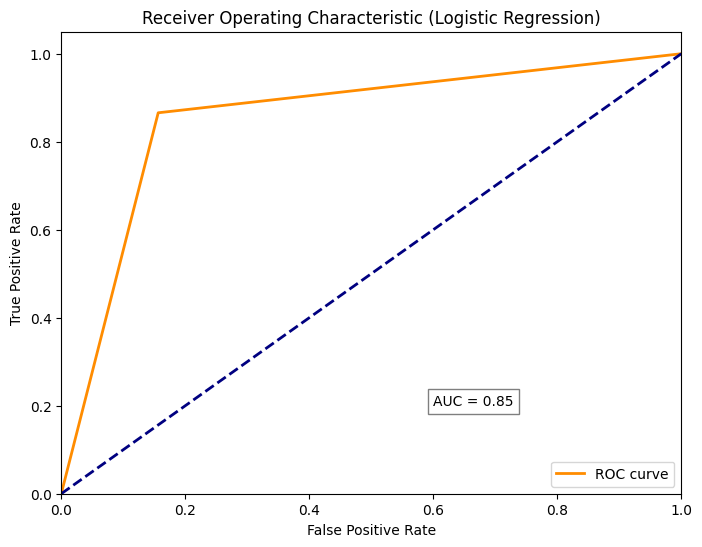

In [ ]:
# Menghasilkan prediksi model dan menggambar kurva ROC
log_reg_train_aucroc = rocAucResult(model_prediction=log_reg_train_pred,
                                    output_data=y_train_smote,
                                    model_name='Logistic Regression')

**Random Forest**

In [ ]:
r_forest_train = RandomForestClassifier(
    criterion="entropy",
    n_estimators=cv_best_params["random forest"]["n_estimators"],
    max_features="sqrt",
    random_state=123
)

In [ ]:
r_forest_train.fit(X_train_smote, y_train_smote)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=123)

In [ ]:
r_forest_train_pred, _ = modelPredictionResult(classifier=r_forest_train,
                                            input_data=X_train_smote,
                                            output_data=y_train_smote)

Confusion Matrix:
[True Negative: 2488	False Negative: 0]
[False Positive: 0	True Positive: 2488]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2488
           1       1.00      1.00      1.00      2488

    accuracy                           1.00      4976
   macro avg       1.00      1.00      1.00      4976
weighted avg       1.00      1.00      1.00      4976



In [ ]:
r_forest_train_score = classScore(model_prediction=r_forest_train_pred,
                                  output_data=y_train_smote)

Classification Score Summary
Classifier Accuracy score: 1.00
Classifier Recall score: 1.00
Classifier f1-score: 1.00
Classifier precision: 1.00


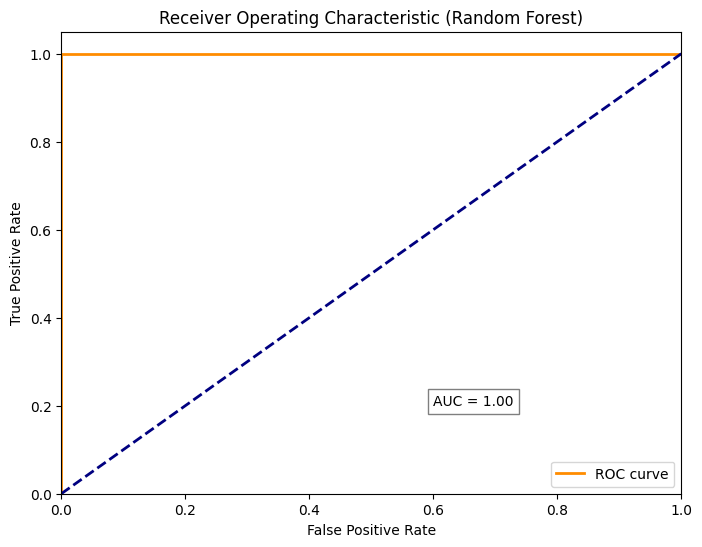

In [ ]:
r_forest_train_aucroc = rocAucResult(model_prediction=r_forest_train_pred,
                                    output_data=y_train_smote,
                                    model_name='Random Forest')

**AdaBoost Classifier**

In [ ]:
adaboost_train = AdaBoostClassifier(n_estimators=cv_best_params["adaboost"]["n_estimators"],
                                    random_state=123)

In [ ]:
adaboost_train.fit(X_train_smote, y_train_smote)

AdaBoostClassifier(n_estimators=500, random_state=123)

In [ ]:
adaboost_train_pred, _ = modelPredictionResult(classifier=adaboost_train,
                                            input_data=X_train_smote,
                                            output_data=y_train_smote)

Confusion Matrix:
[True Negative: 2393	False Negative: 95]
[False Positive: 139	True Positive: 2349]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2488
           1       0.96      0.94      0.95      2488

    accuracy                           0.95      4976
   macro avg       0.95      0.95      0.95      4976
weighted avg       0.95      0.95      0.95      4976



In [ ]:
adaboost_train_score = classScore(model_prediction=adaboost_train_pred,
                                  output_data=y_train_smote)

Classification Score Summary
Classifier Accuracy score: 0.95
Classifier Recall score: 0.94
Classifier f1-score: 0.95
Classifier precision: 0.96


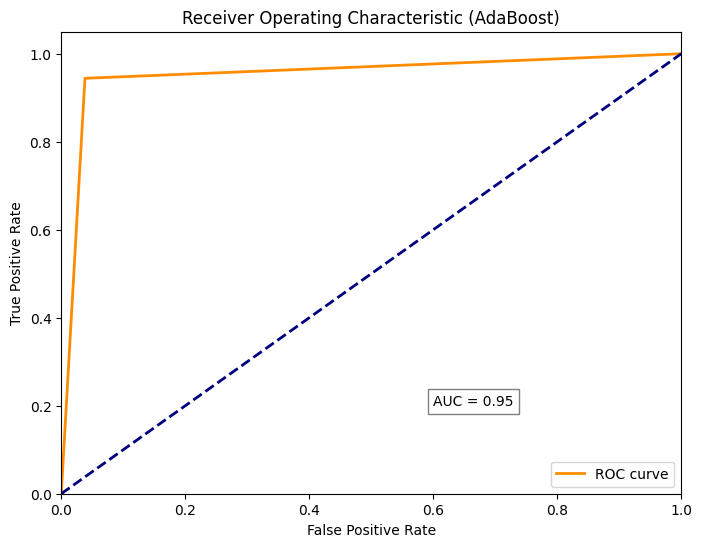

In [ ]:
adaboost_train_aucroc = rocAucResult(model_prediction=adaboost_train_pred,
                                    output_data=y_train_smote,
                                    model_name='AdaBoost')

Train Data Summary

In [ ]:
# Buat list model dan hasil skornya
models = ["Logistic Regression", "Random Forest", "Adaboost"]
scores = [log_reg_train_score, r_forest_train_score, adaboost_train_score]

# Buat DataFrame dengan judul kolom
df_train_scores = pd.DataFrame(columns=["Model", "Accuracy", "Recall", "F1-score", "Precision"])

# Isi DataFrame dengan skor model
for model, score in zip(models, scores):
    lines = score.split('\n')
    accuracy = float(lines[1].split()[-1])
    recall = float(lines[2].split()[-1])
    f1_score = float(lines[3].split()[-1])
    precision = float(lines[4].split()[-1])
    df_train_scores = df_train_scores.append({"Model": model, "Accuracy": accuracy, "Recall": recall, "F1-score": f1_score, "Precision": precision}, ignore_index=True)

# Cetak DataFrame tanpa indeks
print(df_train_scores.to_string(index=False))

              Model  Accuracy  Recall  F1-score  Precision
Logistic Regression      0.85    0.87      0.86       0.85
      Random Forest      1.00    1.00      1.00       1.00
           Adaboost      0.95    0.94      0.95       0.96


### Test Model

**Preprocessing Data Test**

In [ ]:
X_test_categorical = X_test[['international_plan', 'voice_mail_plan']]

# One-hot encoding untuk 'no' dan 'yes'
categorical_ohe_test = pd.get_dummies(X_test_categorical, columns=['international_plan', 'voice_mail_plan'], prefix=['international_plan', 'voice_mail_plan'])

In [ ]:
X_test_numeric = X_test[['account_length', 'number_vmail_messages', 'total_day_minutes',
           'total_day_calls', 'total_day_charge', 'total_eve_minutes',
           'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
           'total_night_calls', 'total_night_charge', 'total_intl_minutes',
           'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']]

X_test_encoded = pd.concat([X_test_numeric, categorical_ohe_test], axis=1)

In [ ]:
X_test_encoded.columns

Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'international_plan_no',
       'international_plan_yes', 'voice_mail_plan_no', 'voice_mail_plan_yes'],
      dtype='object')

In [ ]:
# kolom numerik dari X_test_encoded
X_test_numeric = X_test_encoded[['account_length', 'number_vmail_messages', 'total_day_minutes',
                                'total_day_calls', 'total_day_charge', 'total_eve_minutes',
                                'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
                                'total_night_calls', 'total_night_charge', 'total_intl_minutes',
                                'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']]

# Buat objek scaler baru untuk data test
scaler_test = StandardScaler()
scaler_test.fit(X_test_numeric)

# Standarisasi kolom numerik menggunakan objek scaler_test yang baru
X_test_numeric_scaled = scaler_test.transform(X_test_numeric)

# Mengganti data standar tersebut ke dalam DataFrame dengan nama kolom yang sesuai
X_test_numeric_scaled = pd.DataFrame(X_test_numeric_scaled, columns=X_test_numeric.columns, index=X_test_numeric.index)

# Gabungkan hasil standarisasi kolom numerik dengan kolom kategorikal yang sudah di one-hot encoding
X_test_scaled = pd.concat([X_test_numeric_scaled, categorical_ohe_test], axis=1)

**Test Logistic Regression Model**

In [ ]:
logreg_test_pred, _ = modelPredictionResult(classifier=log_reg_train,
                                           input_data=X_test_scaled,
                                           output_data=y_test)

Confusion Matrix:
[True Negative: 584	False Negative: 41]
[False Positive: 28	True Positive: 43]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       625
           1       0.51      0.61      0.55        71

    accuracy                           0.90       696
   macro avg       0.73      0.77      0.75       696
weighted avg       0.91      0.90      0.90       696



In [ ]:
logreg_test_score = classScore(model_prediction=logreg_test_pred,
                               output_data=y_test)

Classification Score Summary
Classifier Accuracy score: 0.90
Classifier Recall score: 0.61
Classifier f1-score: 0.55
Classifier precision: 0.51


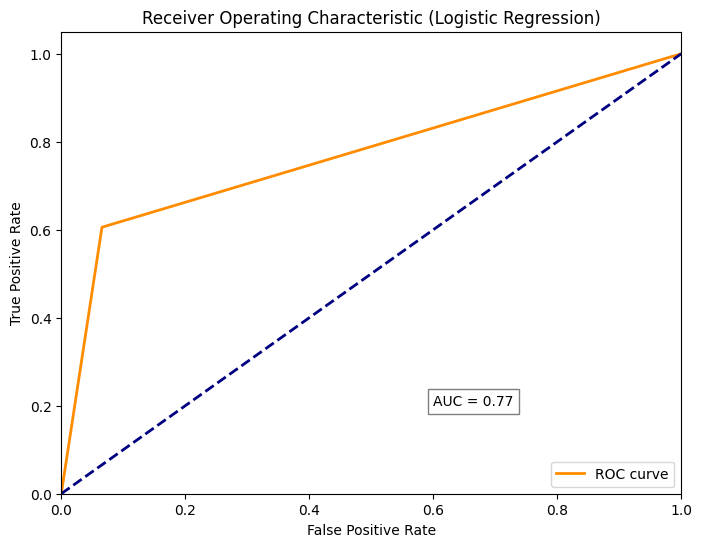

In [ ]:
logreg_test_aucroc = rocAucResult(model_prediction=logreg_test_pred,
                                  output_data=y_test,
                                  model_name="Logistic Regression")

**Test Random Forest Model**

In [ ]:
r_forest_test_pred, _ = modelPredictionResult(classifier=r_forest_train,
                                            input_data=X_test_scaled,
                                            output_data=y_test)

Confusion Matrix:
[True Negative: 483	False Negative: 142]
[False Positive: 29	True Positive: 42]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       625
           1       0.23      0.59      0.33        71

    accuracy                           0.75       696
   macro avg       0.59      0.68      0.59       696
weighted avg       0.87      0.75      0.80       696



In [ ]:
r_forest_test_score = classScore(model_prediction=r_forest_test_pred,
                                  output_data=y_test)

Classification Score Summary
Classifier Accuracy score: 0.75
Classifier Recall score: 0.59
Classifier f1-score: 0.33
Classifier precision: 0.23


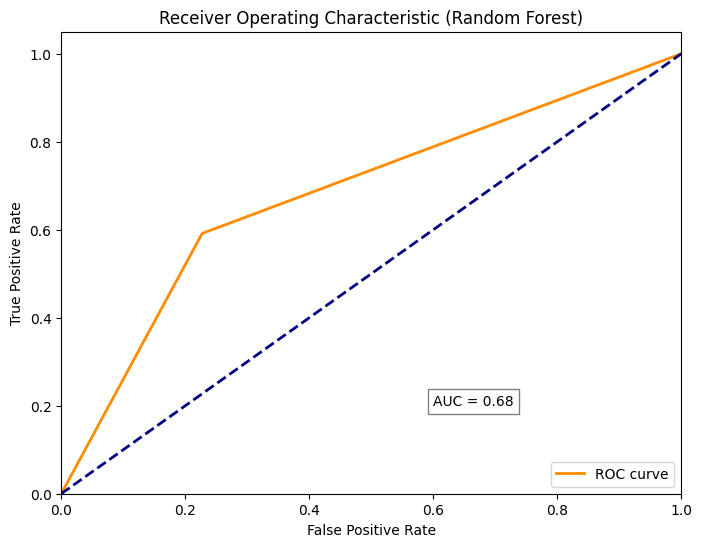

In [ ]:
r_forest_test_aucroc = rocAucResult(model_prediction=r_forest_test_pred,
                                    output_data=y_test,
                                    model_name='Random Forest')

**Test AdaBoost Classifie Model**

In [ ]:
adaboost_test_pred, _ = modelPredictionResult(classifier=adaboost_train,
                                            input_data=X_test_scaled,
                                            output_data=y_test)

Confusion Matrix:
[True Negative: 61	False Negative: 564]
[False Positive: 4	True Positive: 67]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.10      0.18       625
           1       0.11      0.94      0.19        71

    accuracy                           0.18       696
   macro avg       0.52      0.52      0.18       696
weighted avg       0.85      0.18      0.18       696



In [ ]:
adaboost_test_score = classScore(model_prediction=adaboost_test_pred,
                                  output_data=y_test)

Classification Score Summary
Classifier Accuracy score: 0.18
Classifier Recall score: 0.94
Classifier f1-score: 0.19
Classifier precision: 0.11


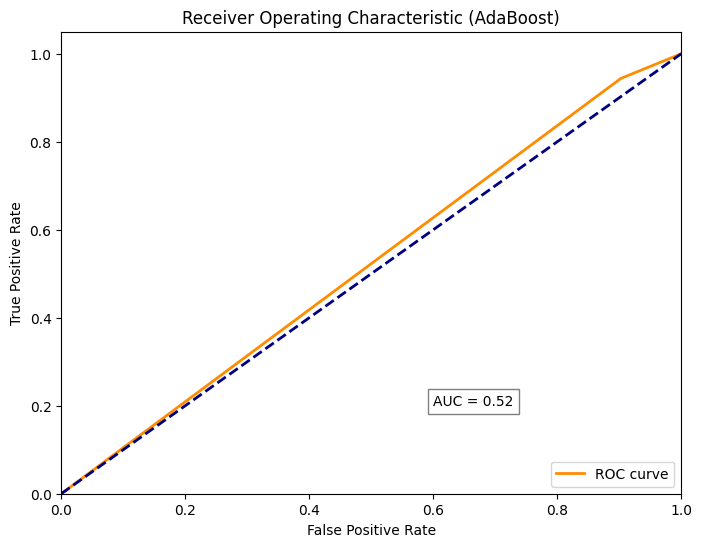

In [ ]:
adaboost_test_aucroc = rocAucResult(model_prediction=adaboost_test_pred,
                                    output_data=y_test,
                                    model_name='AdaBoost')

Train Test Summary

In [ ]:
# Buat list model dan hasil skornya untuk data uji
models = ["Logistic Regression", "Random Forest", "Adaboost"]
test_scores = [logreg_test_score, r_forest_test_score, adaboost_test_score]

# Buat DataFrame dengan judul kolom
df_test_scores = pd.DataFrame(columns=["Model", "Accuracy", "Recall", "F1-score", "Precision"])

# Isi DataFrame dengan skor model untuk data uji
for model, score in zip(models, test_scores):
    lines = score.split('\n')
    accuracy = float(lines[1].split()[-1])
    recall = float(lines[2].split()[-1])
    f1_score = float(lines[3].split()[-1])
    precision = float(lines[4].split()[-1])
    df_test_scores = df_test_scores.append({"Model": model, "Accuracy": accuracy, "Recall": recall, "F1-score": f1_score, "Precision": precision}, ignore_index=True)

# Cetak DataFrame tanpa indeks
print(df_test_scores.to_string(index=False))

              Model  Accuracy  Recall  F1-score  Precision
Logistic Regression      0.90    0.61      0.55       0.51
      Random Forest      0.75    0.59      0.33       0.23
           Adaboost      0.18    0.94      0.19       0.11
